In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

#### Settings

In [3]:
DATA_PATH = "../data/rocov2"

#### Loading Data

In [4]:
df_train = pd.read_csv(os.path.join(DATA_PATH, "processed", "train.csv"))
df_valid = pd.read_csv(os.path.join(DATA_PATH, "processed", "valid.csv"))
df_test = pd.read_csv(os.path.join(DATA_PATH, "processed", "test.csv"))

df_cui = pd.read_csv(os.path.join(DATA_PATH, "unprocessed", "cui_mapping.csv"))

In [5]:
df_train.head()

,ID,Caption,CUIs,CUI_caption
0,ROCOv2_2023_train_000001,Head CT demonstrating left parotiditis.,C0040405,X-Ray Computed Tomography
1,ROCOv2_2023_train_000002,Acquired renal cysts in end-stage renal failur...,C0041618,Ultrasonography
2,ROCOv2_2023_train_000003,Computed tomography of the chest showing the r...,C0040405;C0817096;C0205271,X-Ray Computed Tomography;Chest;Irregular
3,ROCOv2_2023_train_000004,Lateral view of the sacrum showing the low con...,C0002978;C0036033;C0225317,angiogram;Sacral Region;soft tissue
4,ROCOv2_2023_train_000005,Thoracic CT scan showing perihilar pulmonary l...,C0040405;C0817096;C0497156,X-Ray Computed Tomography;Chest;Lymphadenopathy


### Top K CUIs

In [6]:
cui_freq = {}
for i in tqdm(range(len(df_train))):
    cuis = df_train.iloc[i]["CUIs"].split(";")
    for cui in cuis:
        if cui in cui_freq.keys():
            cui_freq[cui] += 1
        else:
            cui_freq[cui] = 1

k = 20
sorted_cui_freq = dict(sorted(cui_freq.items(), key=lambda item: item[1], reverse=True))
top_kby2_cui = dict(list(sorted_cui_freq.items())[k//2:k])
top_k_cui = dict(list(sorted_cui_freq.items())[:k])
top_k_cui


  0%|          | 0/60162 [00:00<?, ?it/s]

{'C0040405': 20536,
 'C1306645': 16679,
 'C0024485': 9841,
 'C0041618': 8333,
 'C0817096': 7530,
 'C1999039': 7148,
 'C0002978': 3965,
 'C1996865': 3401,
 'C0037303': 3340,
 'C0000726': 3184,
 'C0030797': 2688,
 'C0023216': 2351,
 'C0205129': 2187,
 'C0027651': 1397,
 'C0037949': 1294,
 'C0444611': 1267,
 'C0205207': 1157,
 'C1140618': 1126,
 'C0023884': 993,
 'C0018787': 908}

In [14]:
viz_k = 50
viz_k_cui = dict(list(sorted_cui_freq.items())[:viz_k])

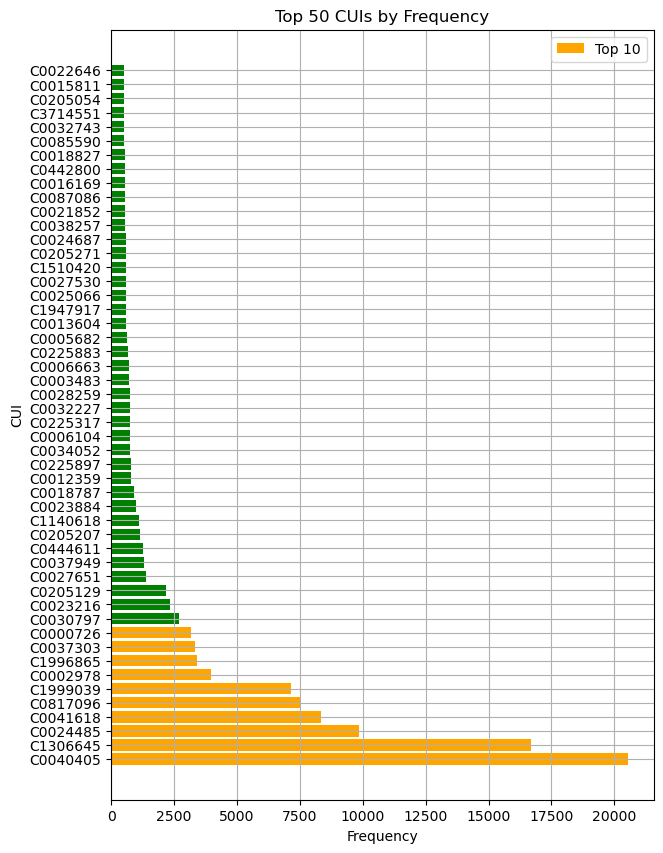

In [29]:
#plot cui_freq
#color the first 10 cuis orange, the next 10 blue, and the rest green
# make the bar charts horizontal, left to right
# add cui names to the right of the bars
# add frequency to the left of the bars
# add a title and labels
# add a legend
# add a grid

fig, ax = plt.subplots(figsize=(7, 10))  # Reduced width from 10 to 8
colors = ["orange"]*10 + ["green"]*40
ax.barh(list(viz_k_cui.keys()), list(viz_k_cui.values()), color=colors)
ax.set_title("Top 50 CUIs by Frequency")
ax.set_xlabel("Frequency")
ax.set_ylabel("CUI")
ax.legend(["Top 10", "Next 10", "Rest"])
ax.grid()
plt.savefig("../fig/top_50_cui_freq.png")


In [33]:
with open(os.path.join(DATA_PATH, "cui_freq.txt"), "w") as f:
    for cui, freq in sorted_cui_freq.items():
        f.write(f"{cui} : {freq}\n")

In [34]:
df_cui_freq = pd.DataFrame(sorted_cui_freq.items(), columns=["CUI", "Frequency"])
df_cui_freq.describe()

,Frequency
count,1934.000000
mean,103.204757
std,738.342287
min,1.000000
25%,11.000000
50%,19.000000
75%,44.000000
max,20536.000000


In [35]:
percentiles = [95, 99]
for p in percentiles:
    print(f"{p} percentile: {df_cui_freq['Frequency'].quantile(p/100)}")

95 percentile: 298.3499999999999
99 percentile: 874.6700000000073


In [36]:
top_k_cui_set = set(top_k_cui.keys())
rows_to_remove = []

for i in tqdm(range(len(df_train))):
    cuis = df_train.iloc[i]["CUIs"].split(";")
    if len(top_k_cui_set.intersection(set(cuis))) != len(cuis):
        rows_to_remove.append(i)

df_train = df_train.drop(rows_to_remove)
df_train = df_train.reset_index(drop=True)

df_train.shape

  0%|          | 0/60162 [00:00<?, ?it/s]

(10311, 4)

In [37]:
rows_to_remove = []

for i in tqdm(range(len(df_valid))):
    cuis = df_valid.iloc[i]["CUIs"].split(";")
    if len(top_k_cui_set.intersection(set(cuis))) != len(cuis):
        rows_to_remove.append(i)

df_valid = df_valid.drop(rows_to_remove)
df_valid = df_valid.reset_index(drop=True)

df_valid.shape

  0%|          | 0/9945 [00:00<?, ?it/s]

(1628, 4)

In [38]:
rows_to_remove = []

for i in tqdm(range(len(df_test))):
    cuis = df_test.iloc[i]["CUIs"].split(";")
    if len(top_k_cui_set.intersection(set(cuis))) != len(cuis):
        rows_to_remove.append(i)

df_test = df_test.drop(rows_to_remove)
df_test = df_test.reset_index(drop=True)

df_test.shape

  0%|          | 0/9972 [00:00<?, ?it/s]

(1549, 4)

In [39]:
df_train.to_csv(os.path.join(DATA_PATH, "processed", "train_top_20_cui.csv"), index=False)
df_valid.to_csv(os.path.join(DATA_PATH, "processed", "valid_top_20_cui.csv"), index=False)
df_test.to_csv(os.path.join(DATA_PATH, "processed", "test_top_20_cui.csv"), index=False)

#### Number of CUIs vs Number of Images

In [40]:
count_num_CUI_per_img = {}
for i in tqdm(range(len(df_train))):
    cuis = df_train.iloc[i]["CUIs"].split(";")
    count_num_CUI_per_img[len(cuis)] = count_num_CUI_per_img.get(len(cuis), 0) + 1

count_num_CUI_per_img

  0%|          | 0/10311 [00:00<?, ?it/s]

{1: 6568, 2: 1893, 3: 1845, 4: 5}

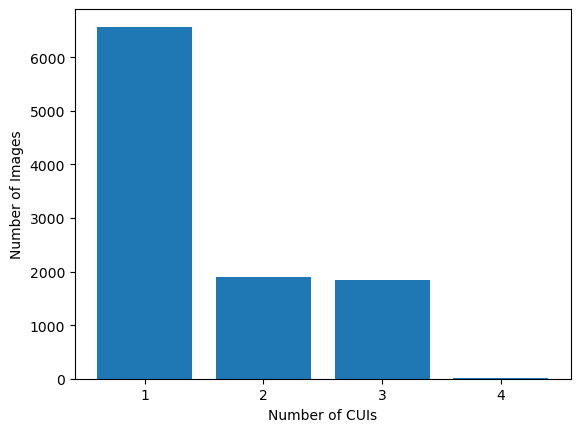

Number of images with 1 CUIs 6568
Number of images with 2 CUIs 1893
Number of images with 3 CUIs 1845
Number of images with 4 CUIs 5


In [41]:
plt.bar(count_num_CUI_per_img.keys(), count_num_CUI_per_img.values())
plt.xticks(range(1, max(count_num_CUI_per_img.keys()) + 1))
plt.xlabel("Number of CUIs")
plt.ylabel("Number of Images")
plt.show()

keys = sorted(count_num_CUI_per_img.keys())
for k in keys:
    print(f"Number of images with {k} CUIs", count_num_CUI_per_img[k])

In [42]:
total, count = 0, 0
for k, v in count_num_CUI_per_img.items():
    total += k * v
    count += v

print("Average number of CUIs per image:", total / count)

Average number of CUIs per image: 1.5429153331393657
